# IANNWTF - Homework 08
(by Group 17 - Nils Niehaus, Philipp Bauer, Marlon Dammann)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.manifold import TSNE

## 1 - Dataset

In [2]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
test = [elem for elem in train_ds.take(1)][0][0]
test = tf.clip_by_value(tf.cast(test, 'float32') + tf.random.normal(shape=(28,28,1),mean=0,stddev=5*2), clip_value_min=0, clip_value_max=255)
test = tf.expand_dims(test/255., axis=2)

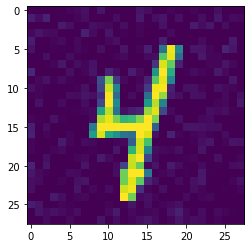

In [4]:
def tensor_to_img(tensor):
    tensor = tf.squeeze(tensor,axis=2)
    img = tensor.numpy()
    plt.imshow(np.squeeze(img))
tensor_to_img(test)

In [5]:
def preprocess_mnist(dataset, noisification=2):
    '''Remove the label/target entirely and cast into float'''
    dataset = dataset.map(lambda img, target: tf.cast(img, 'float32'))
    '''Add noise and clip the values between 0 and 255'''
    dataset = dataset.map(lambda img: (img+tf.random.normal(shape=(28,28,1),mean=0,stddev=5*noisification), img))
    dataset = dataset.map(lambda noisy, original: (tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=255), original))
    '''Normalization of the clipped tensor'''    
    dataset = dataset.map(lambda noisy, original: (noisy/255., original/255.))
    '''Expand dimensions for expected color channel'''
    dataset = dataset.map(lambda noisy, original: (tf.expand_dims(noisy, axis=2),tf.expand_dims(original, axis=2)))
    
    '''Shuffle, batch, prefetch'''
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(20)
    return dataset

In [6]:
dataset = {'training' : train_ds.apply(preprocess_mnist), 'test' : test_ds.apply(preprocess_mnist)}

## 2 - Model

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64,kernel_size=5,strides=1,padding='same',activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPooling3D(pool_size=2,strides=2,padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling3D(pool_size=2,strides=2,padding='same')
        self.globalavg = tf.keras.layers.GlobalAveragePooling3D()
        self.output_layer = tf.keras.layers.Dense(units=10, activation='sigmoid')
    
    def call(self, inputs):
        '''The model\'s call method for forwarding the input through the layers.'''
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.globalavg(x)
        x = self.output_layer(x)
        return x

In [8]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.input_layer = tf.keras.layers.Dense(units=7*7*1*1, activation='sigmoid')
        self.tconv1 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')
        self.tconv2 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=5,strides=2,padding='same',activation='relu')
        self.output_layer = tf.keras.layers.Conv2D(filters=1,kernel_size=5,strides=1,padding='same',activation='sigmoid')
    
    def call(self, inputs):
        '''The model\'s call method for forwarding the input through the layers.'''
        batch_size = inputs.shape[0]
        x = self.input_layer(inputs)
        x = tf.reshape(x, (batch_size,7,7,1))
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.output_layer(x)
        x = tf.expand_dims(x, axis=3)
        return x

In [9]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, inputs, return_embedding=False, from_embedding=False):
        '''The model\'s call method for forwarding the input through the layers.'''
        if from_embedding:
            return self.decoder(inputs)
        
        x = self.encoder(inputs)
        embedding = x
        x = self.decoder(x)
        if return_embedding == True:
            return x, embedding
        else:
            return x

In [10]:
[elem for elem in dataset['training'].take(1)][0][0].shape == Autoencoder()([elem for elem in dataset['training'].take(1)][0][0]).shape

True

## 3 - Training

In [11]:
model_performance = {'training': {'loss' : []},
                     'test': {'loss' : []},
                    'batchvis' : []}

In [12]:
def get_loss(model, data_split, loss_function, mode_name):
    '''Returns the loss of the model on a given split of the data.'''
    loss_aggregator = []

    for (input, target) in tqdm(data_split,desc='Sampling Loss for ' + str(mode_name) + ' data'):
        prediction = model(input)
        sample_loss = loss_function(target, prediction)
        loss_aggregator.append(sample_loss.numpy())
        
    loss = tf.reduce_mean(loss_aggregator)
    return loss

In [13]:
def performance_test(model, data_split, loss_function, model_performance, mode_name):
    '''Evaluation of loss and accuracy of a model on a data split.'''
    loss = get_loss(model, data_split, loss_function, mode_name)
    model_performance[mode_name]['loss'].append(loss.numpy())
    if mode_name == 'test':
        images = [elem[0].numpy() for elem in dataset['test'].take(1)] + [model(elem[0]).numpy() for elem in dataset['test'].take(1)]
        batch = []
        for i in range(2):
            for j in range(16):
                batch.append(images[i][j])
        images = np.squeeze(batch, axis=3)
        model_performance['batchvis'].append(images)
        print('Test loss for current epoch: ', model_performance['test']['loss'][-1])

In [14]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [15]:
def train_model(model, dataset, optimizer, loss_function, num_epochs, model_performance):
    
    '''Initial performance of the model without training'''
    for data, name in zip(list(dataset.values()),list(dataset.keys())):
        performance_test(model, data, loss_function, model_performance, mode_name=name)
    
    for epoch in range(num_epochs):
        for input,target in tqdm(dataset['training'],desc='Epoch '+str(epoch+1)):
            train_step(model, input, target, loss_function, optimizer)
        for data, name in zip(list(dataset.values()),list(dataset.keys())):
            performance_test(model, data, loss_function, model_performance, mode_name=name)

In [16]:
tf.keras.backend.clear_session()

'''Hyperparameters'''
num_epochs = 10
learning_rate = 0.001

'''Loss function'''
loss_func = tf.keras.losses.BinaryCrossentropy()

'''Adam as chosen optimizer'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

'''Model'''
model = Autoencoder()

In [17]:
train_model(model, dataset, optimizer, loss_func, num_epochs, model_performance)

Sampling Loss for test data: 100%|██████████| 625/625 [00:12<00:00, 51.80it/s]


Test loss for current epoch:  0.6961751


Sampling Loss for test data: 100%|██████████| 625/625 [00:11<00:00, 55.96it/s]


Test loss for current epoch:  0.24314761


Sampling Loss for test data: 100%|██████████| 625/625 [00:11<00:00, 55.88it/s]


Test loss for current epoch:  0.23881939


Sampling Loss for test data: 100%|██████████| 625/625 [00:11<00:00, 56.74it/s]


Test loss for current epoch:  0.23773183


Sampling Loss for test data: 100%|██████████| 625/625 [00:11<00:00, 56.75it/s]


Test loss for current epoch:  0.23606892


Sampling Loss for test data: 100%|██████████| 625/625 [00:10<00:00, 57.04it/s]


Test loss for current epoch:  0.23481876


Sampling Loss for test data: 100%|██████████| 625/625 [00:10<00:00, 57.49it/s]


Test loss for current epoch:  0.23336229


Sampling Loss for test data: 100%|██████████| 625/625 [00:10<00:00, 57.26it/s]


Test loss for current epoch:  0.23165202


Sampling Loss for test data: 100%|██████████| 625/625 [00:10<00:00, 57.05it/s]


Test loss for current epoch:  0.23066597


Sampling Loss for test data: 100%|██████████| 625/625 [00:11<00:00, 56.05it/s]


Test loss for current epoch:  0.228337


Sampling Loss for test data: 100%|██████████| 625/625 [00:11<00:00, 56.79it/s]


Test loss for current epoch:  0.22704636


In [18]:
def visualize_progress():
    counter = 0
    for images in model_performance['batchvis']:
        num_row = 2
        num_col = 16
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(num_row*num_col):
            ax = axes[i//num_col, i%num_col]
            ax.imshow(np.squeeze(images[i], axis=2))
            ax.set_axis_off()
        plt.title("Epoch " + str(counter))
        counter += 1
        plt.tight_layout()
        plt.show()

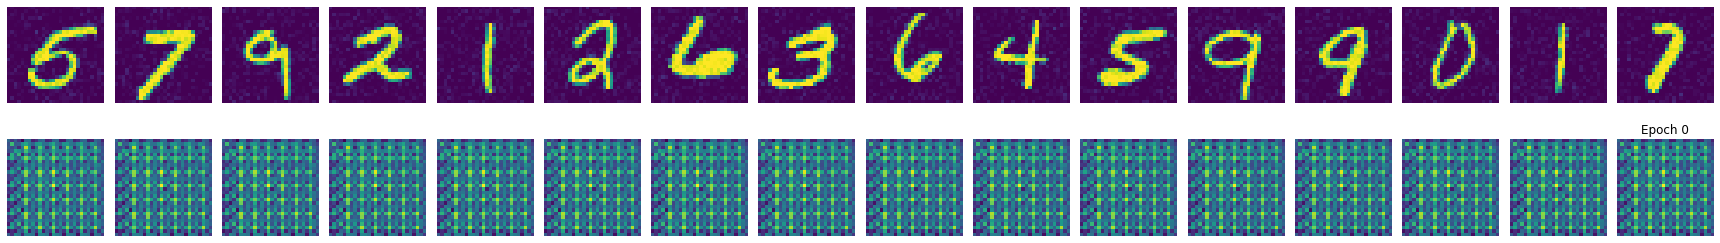

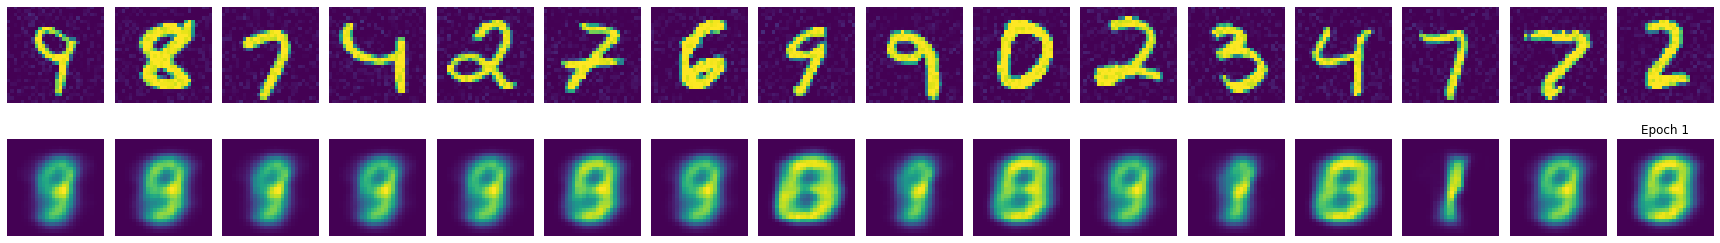

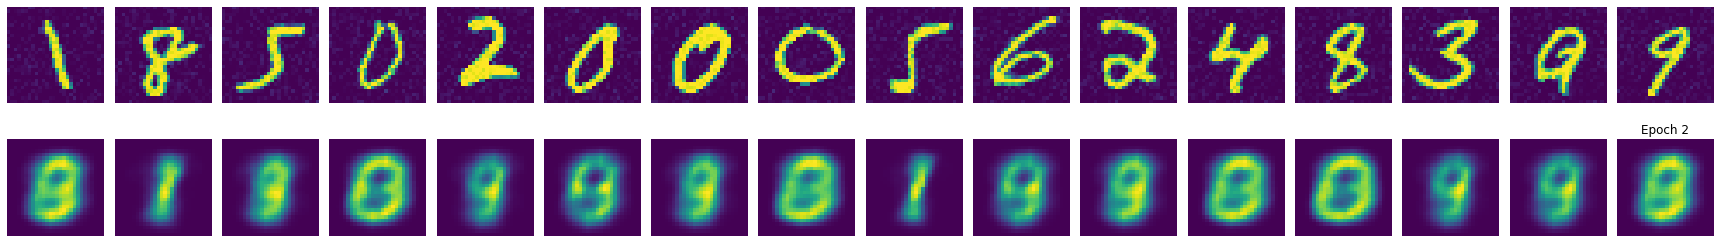

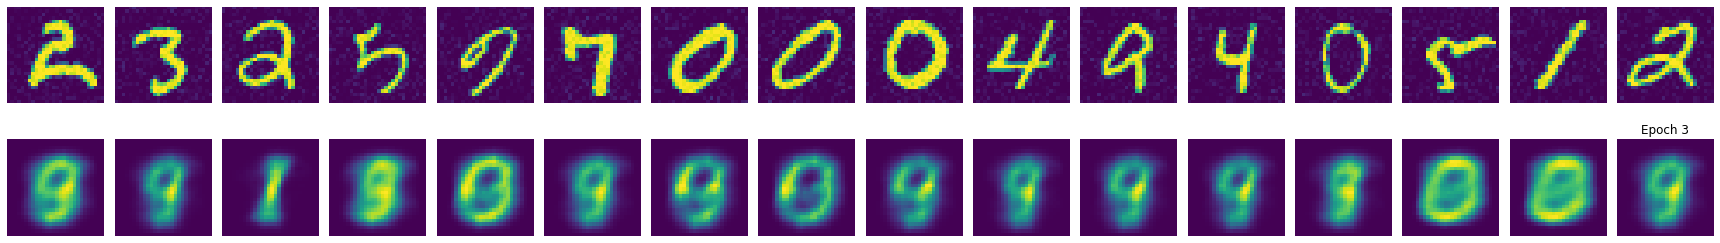

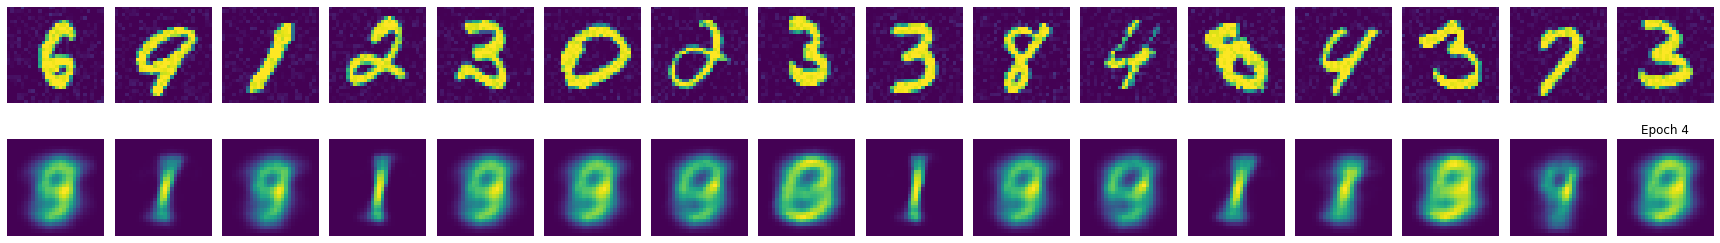

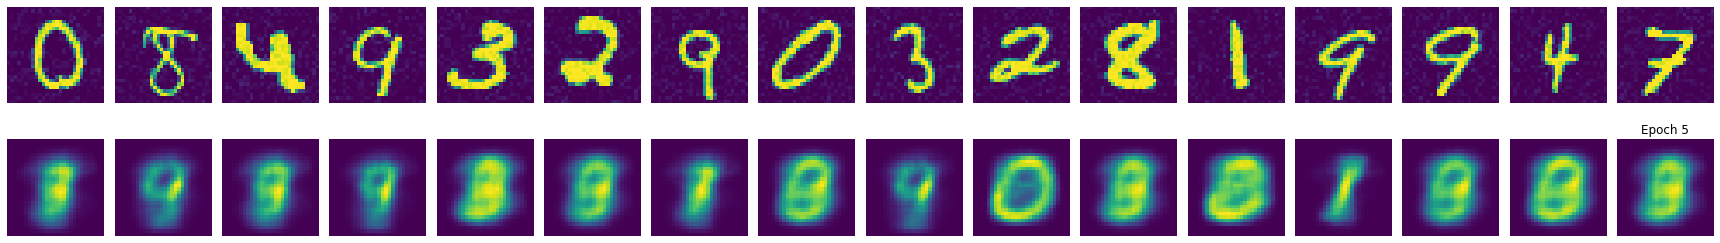

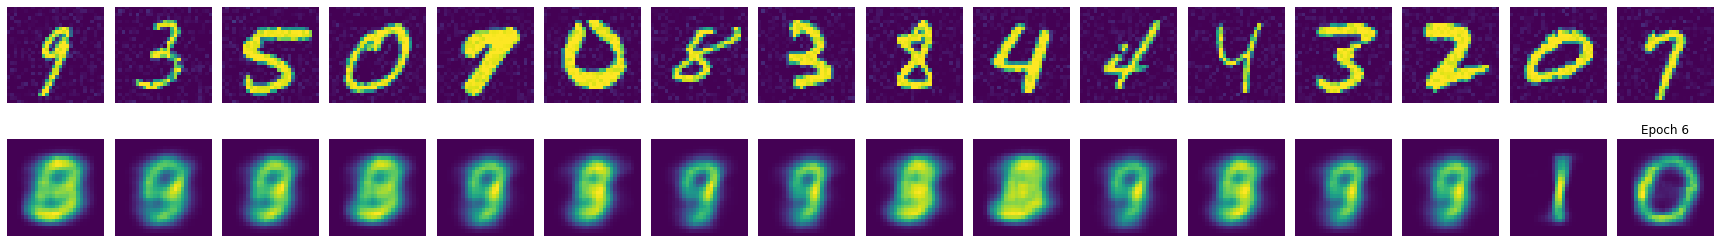

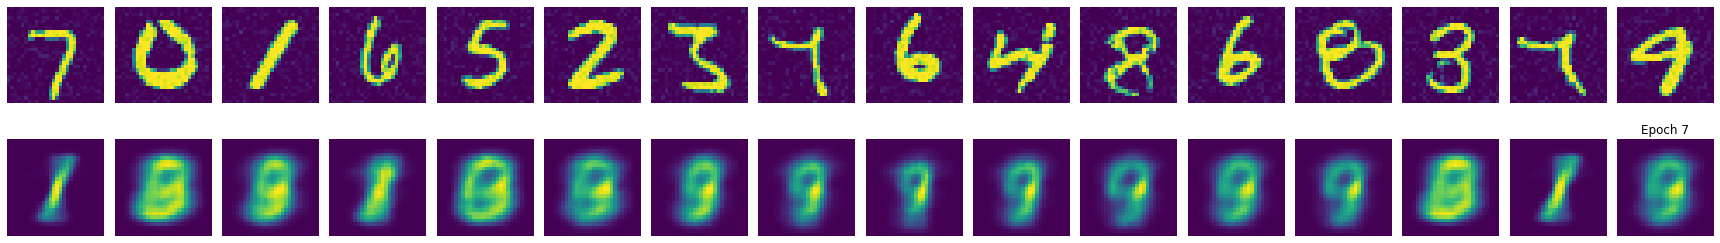

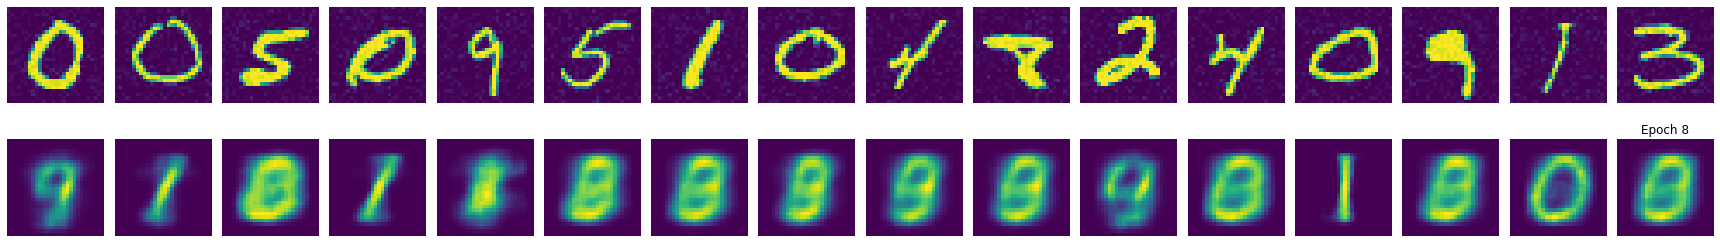

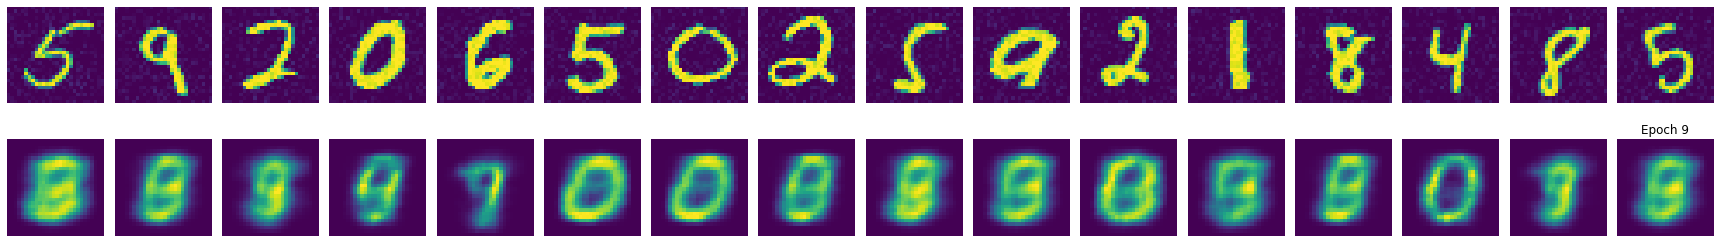

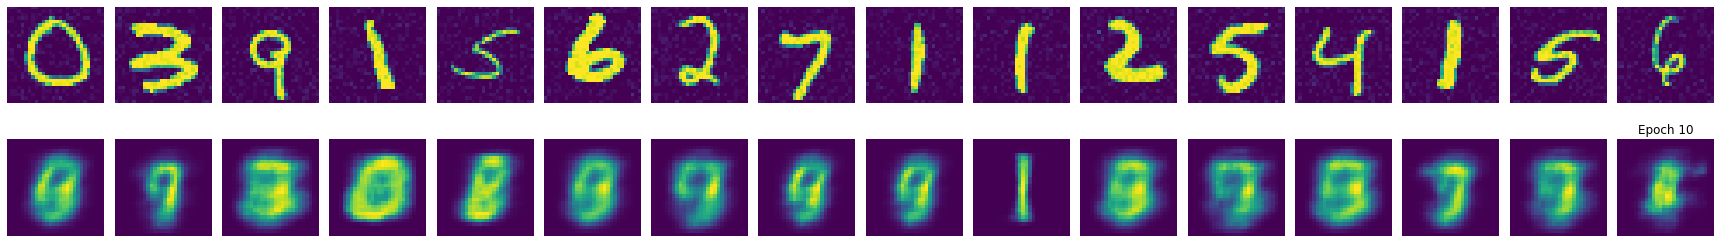

In [19]:
visualize_progress()

In [20]:
def visualize_performance():
    fig, ax = plt.subplots(1,1,figsize=(15, 4))
    line1, = ax.plot(model_performance['training']['loss'])
    line2, = ax.plot(model_performance['test']['loss'])
    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")
    ax.legend((line1,line2),("training","test"))
    plt.show()

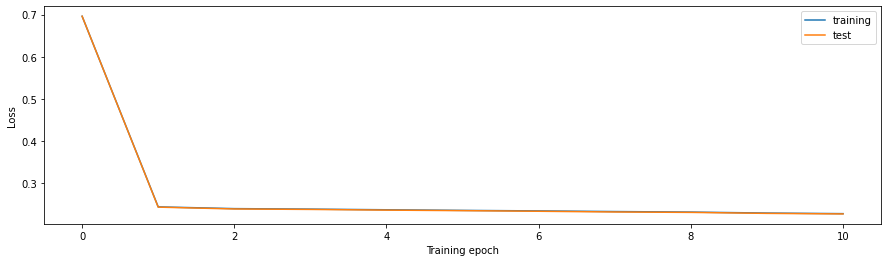

In [21]:
visualize_performance()

## 4 - Latent space analysis

In [22]:
def preprocess_for_tsne(dataset, noisification=2):
    '''Remove the label/target entirely and cast into float'''
    dataset = dataset.map(lambda img, target: (tf.cast(img, 'float32'), target))
    '''Normalization of the clipped tensor'''    
    dataset = dataset.map(lambda img, target: (img/255., target))
    '''Expand dimensions for expected color channel and batch dim'''
    dataset = dataset.map(lambda img, target: (tf.expand_dims(img, axis=2),target))
    dataset = dataset.map(lambda img, target: (tf.expand_dims(img, axis=0),target))

    return dataset

In [23]:
data = test_ds.take(1000)
data = data.apply(preprocess_for_tsne)
Y = [datum[1].numpy() for datum in data]
X = [model(datum[0],return_embedding=True)[1].numpy()[0] for datum in data]

'''Store two for analysis later on'''
analysis = (X[0:2],Y[0:2],[model(datum[0]).numpy()[0] for datum in data][0:2])

In [24]:
tsne = TSNE()
dimred = tsne.fit_transform(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


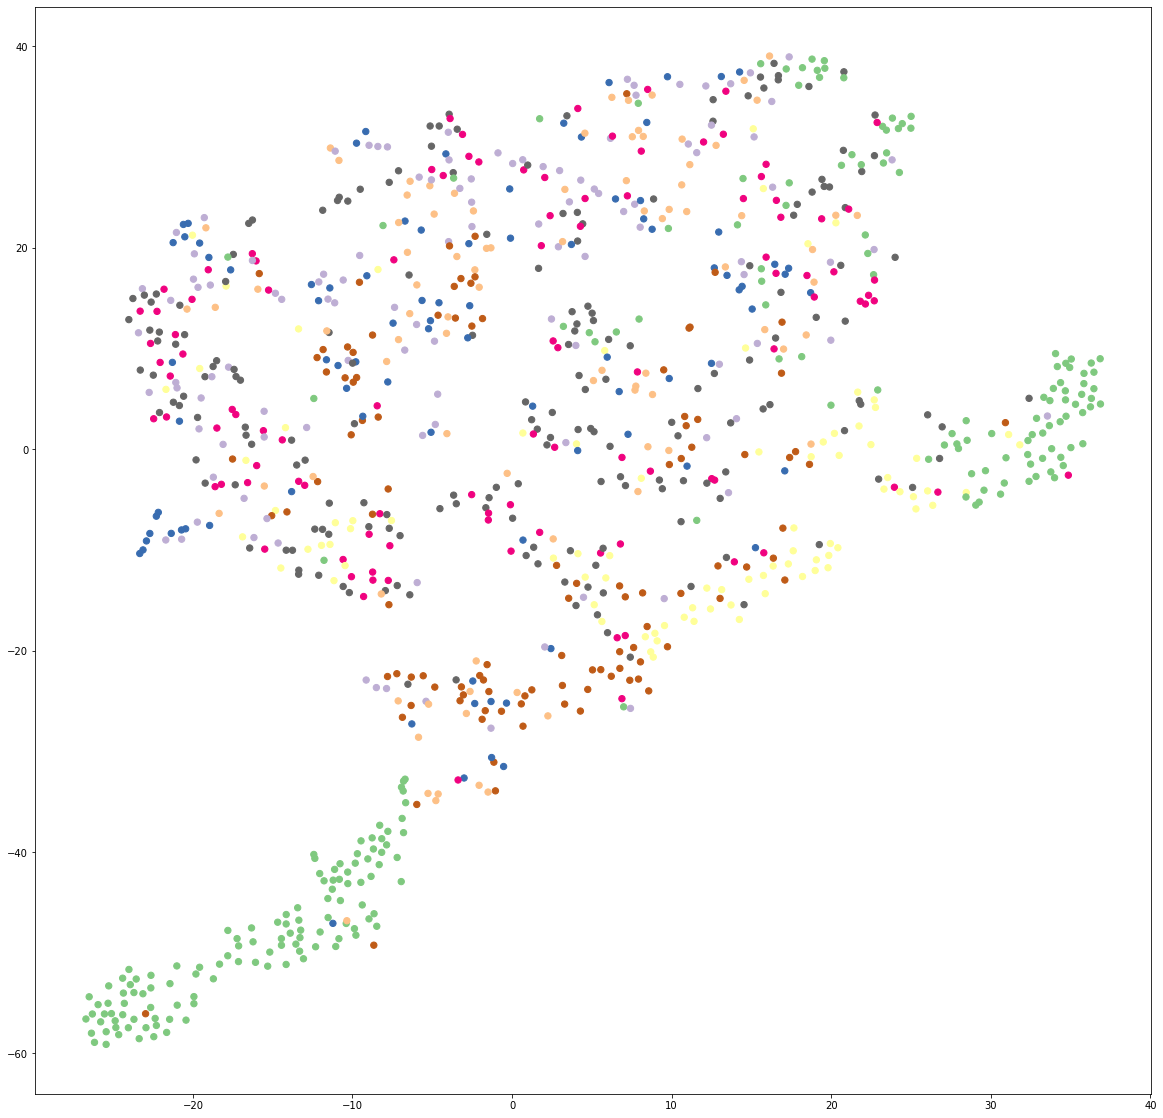

In [25]:
f = plt.figure(figsize=(20, 20))
ax = plt.subplot()
sc = ax.scatter(dimred[:,0], dimred[:,1], s=40, c=Y, cmap='Accent')

The clustering was not really successfull.  
This may either be due to not using a VAE instead of a simple Autoencoder, or due to the generally weak performance of our Autoencoder, even after the training periods.  
Overall a certain degree of class-separation was achieved, however, it is far beneath what was expected.  

# Linear Interpolation
## Single sample

In [57]:
def calculate_vector(points):
    '''Creates a vector describing the line between p1 and p2'''
    return points[1]-points[0]

In [58]:
def create_embeddings(vec,start,scalars=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    '''Uses starting point and the vector to create embeddings corresponding to scalar values'''
    embeddings = []
    for scalar in scalars:
        embeddings.append(np.add(start,np.add(vec,scalar)))
    return embeddings

In [59]:
def interpolate_and_visualize(analysis, model):
    sample1 = (analysis[0][0],analysis[1][0],analysis[2][0])
    sample2 = (analysis[0][1],analysis[1][1],analysis[2][1])
    
    vec = calculate_vector([sample1[0],sample2[0]])
    embeddings = create_embeddings(vec,sample1[0])
    
    images = []
    for embedding in embeddings:
        image = model(tf.expand_dims(tf.constant(embedding),axis=0),from_embedding=True).numpy()
        image = np.squeeze(image, axis=3)
        image = np.squeeze(image, axis=0)
        image = np.squeeze(image, axis=2)
        images.append(image)
    
    num_row = 1
    num_col = 9
    fig, axes = plt.subplots(num_row, num_col, figsize=(15,15))
    for i in range(num_row*num_col):
        ax = axes[i%num_col]
        ax.imshow(images[i])
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

Interpolation result for single sample


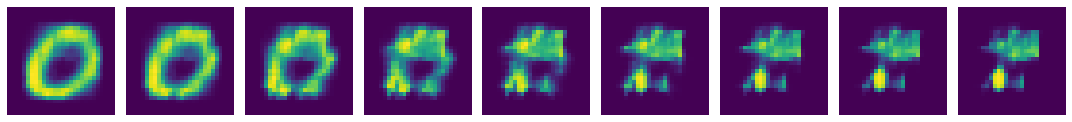

In [60]:
print('Interpolation result for single sample')
interpolate_and_visualize(analysis, model)

## Centroid Linear Interpolation

In [51]:
cluster_centroids = {}
for label in range(9):
    cluster_centroids[label] = []
    for i in range(len(X)):
      if Y[i] == label:
        cluster_centroids[label] += [X[i]]
    cluster_centroids[label] = 1/len(cluster_centroids[label]) * np.sum([cluster_centroids[label]],axis=1)
cluster_centroids

{0: array([[1.        , 0.01277786, 1.        , 0.7335445 , 0.5633441 ,
         0.49999   , 0.38280812, 1.        , 0.99999756, 0.23118457]],
       dtype=float32),
 1: array([[0.99999994, 0.71082497, 0.9999999 , 0.30981672, 0.37475273,
         0.4773373 , 0.9315934 , 0.99999994, 0.4851571 , 0.02130136]],
       dtype=float32),
 2: array([[1.        , 0.03706732, 1.        , 0.70667917, 0.27706245,
         0.25381094, 0.72768337, 1.        , 0.99974257, 0.12336027]],
       dtype=float32),
 3: array([[1.        , 0.0908677 , 1.        , 0.7124127 , 0.30190006,
         0.33307436, 0.72967464, 1.        , 0.99511576, 0.12465245]],
       dtype=float32),
 4: array([[1.        , 0.04666742, 1.        , 0.4447025 , 0.40216666,
         0.4857703 , 0.6839819 , 1.        , 0.9992085 , 0.04552812]],
       dtype=float32),
 5: array([[1.        , 0.08955652, 1.        , 0.66447514, 0.24352968,
         0.3005918 , 0.768817  , 1.        , 0.992752  , 0.08572295]],
       dtype=float32),
 6: 

In [61]:
def interpolate_and_visualize_c(centroid_pair, model):
    vec = calculate_vector([centroid_pair[0],centroid_pair[0]])
    embeddings = create_embeddings(vec,centroid_pair[0])
    
    images = []
    for embedding in embeddings:
        image = model(tf.expand_dims(tf.constant(embedding),axis=0),from_embedding=True).numpy()
        image = np.squeeze(image, axis=3)
        image = np.squeeze(image, axis=0)
        image = np.squeeze(image, axis=2)
        images.append(image)
    
    num_row = 1
    num_col = 11
    fig, axes = plt.subplots(num_row, num_col, figsize=(15,15))
    for i in range(num_row*num_col):
        ax = axes[i%num_col]
        ax.imshow(images[i])
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

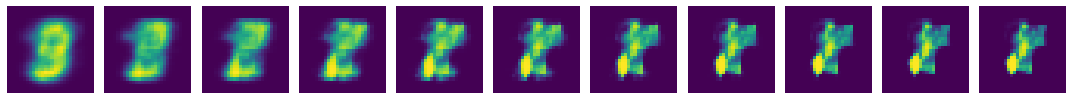

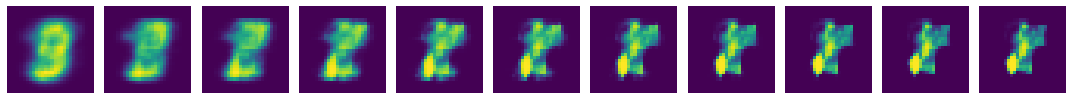

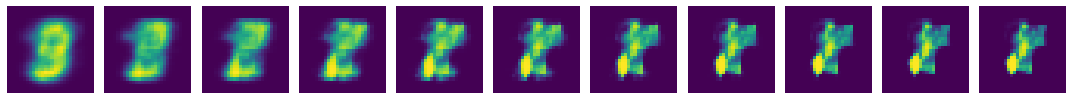

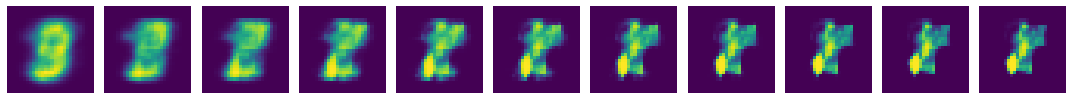

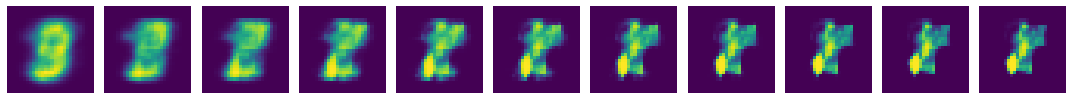

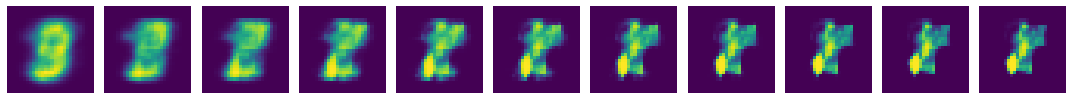

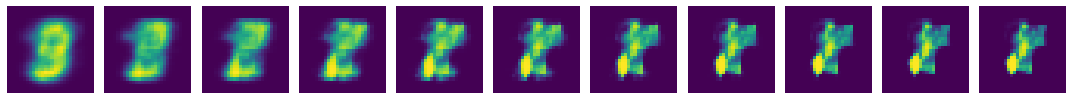

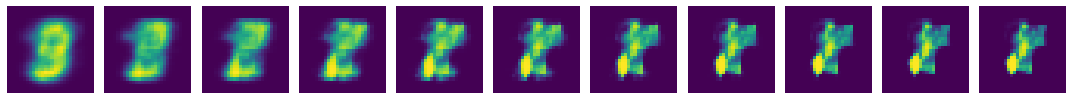

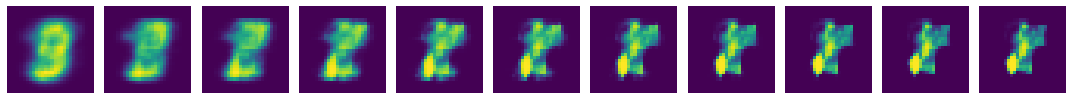

In [62]:
for label_pair in [(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9)]:
  interpolate_and_visualize_c([cluster_centroids[label_pair[0]],label_pair[1]],model)

As seen above, Linear Interpolation results are very poor for our model.  
This is most likely due to the overall model performance and of course also because we did not use an VAE.